In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import scipy.io
import fairseq
import glob
import numpy as np

/home/sensho/anaconda3/envs/speech_decoding/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Audio files

In [2]:
audio_file_num = 12
audio_paths = [f"../data/Brennan2018/audio/DownTheRabbitHoleFinal_SoundFile{i+1}.wav" for i in range(audio_file_num)]

stacked_waveforms = []
total_length = 0
for audio_path in audio_paths:
    waveform, sample_rate = torchaudio.load(filepath=audio_path)
    stacked_waveforms.append(waveform.T)
    length = waveform.shape[1] / sample_rate

    print(f"waveform: {waveform.shape}")
    print(f"sample_rate: {sample_rate}")
    print(f"length: {length} secs")

    total_length += length

waveform: torch.Size([1, 2537541])
sample_rate: 44100
length: 57.54061224489796 secs
waveform: torch.Size([1, 2683273])
sample_rate: 44100
length: 60.84519274376417 secs
waveform: torch.Size([1, 2789741])
sample_rate: 44100
length: 63.25943310657596 secs
waveform: torch.Size([1, 3086496])
sample_rate: 44100
length: 69.98857142857143 secs
waveform: torch.Size([1, 2922619])
sample_rate: 44100
length: 66.27253968253969 secs
waveform: torch.Size([1, 2812590])
sample_rate: 44100
length: 63.77755102040816 secs
waveform: torch.Size([1, 2773751])
sample_rate: 44100
length: 62.896848072562356 secs
waveform: torch.Size([1, 2527398])
sample_rate: 44100
length: 57.31061224489796 secs
waveform: torch.Size([1, 2523673])
sample_rate: 44100
length: 57.22614512471655 secs
waveform: torch.Size([1, 2701992])
sample_rate: 44100
length: 61.26965986394558 secs
waveform: torch.Size([1, 2477105])
sample_rate: 44100
length: 56.17018140589569 secs
waveform: torch.Size([1, 2071953])
sample_rate: 44100
length: 46

In [3]:
merged_waveform = torch.cat(stacked_waveforms).T

In [4]:
merged_waveform.shape

torch.Size([1, 31908132])

In [5]:
sample_rate

44100

In [34]:
print(f"Total audio length: {merged_waveform.shape[1] / sample_rate} secs")

Total audio length: 723.5404081632653 secs


Pop unneeded keys from the model config dict so that I can load without an error

In [7]:
from omegaconf import DictConfig, open_dict

cp_path = '../weights/xlsr_53_56k.pt'
cp = torch.load(cp_path)
unneeded_keys = ['eval_wer','eval_wer_config', 'eval_wer_tokenizer', 'eval_wer_post_process', 'autoregressive']
cfg = DictConfig(cp['cfg'])
with open_dict(cfg):
    for k in unneeded_keys:
        cfg.task.pop(k)
cp['cfg'] = cfg
torch.save(cp, '../weights/xlsr_53_56k_new.pt')

In [8]:
# cp_path = '../weights/wav2vec_small.pt'
cp_path = '../weights/xlsr_53_56k_new.pt'
# model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model, _ = fairseq.checkpoint_utils.load_model_ensemble([cp_path])
model = model[0]
model.eval()

z = model.feature_extractor(merged_waveform)
# c = model.feature_aggregator(z)

print(z.shape)

torch.Size([1, 512, 99712])


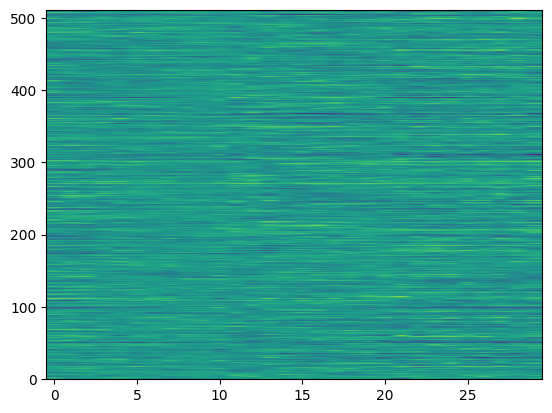

In [16]:
z = model.feature_extractor(merged_waveform)
z = z.detach()
plt.imshow(z[0,:,1000:1030], origin="lower", aspect="auto")

In [3]:
z = torch.load("../data/Brennan2018/Y_embeds/embd_xlsr_53_56k.pt")
print(z.shape)

torch.Size([512, 99712])


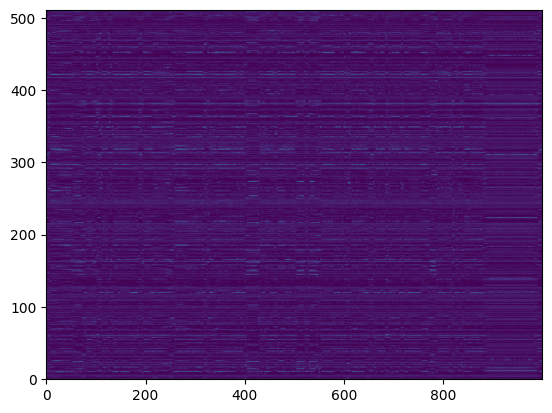

In [8]:
z.requires_grad = False
plt.imshow(z[:,:1000], origin="lower", aspect="auto")

# Raw EEG files

In [3]:
matfile_path = "../data/Brennan2018/raw/S01.mat"
mat_raw = scipy.io.loadmat(matfile_path)["raw"][0,0]
label = [e[0] for e in mat_raw["label"].squeeze()]
print(label)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 'VEOG', 'Aux5']


In [47]:
matfile_paths = glob.glob("../data/Brennan2018/raw/*.mat")

for matfile_path in matfile_paths:
    mat_raw = scipy.io.loadmat(matfile_path)["raw"][0,0]
    eeg_raw = mat_raw["trial"][0,0]
    fsample = mat_raw["fsample"][0,0]
    label = [e[0] for e in mat_raw["label"].squeeze()]

    # print(eeg_raw.shape)
    # print(f"fsample: {fsample}")
    print(f"{eeg_raw.shape} length: {eeg_raw.shape[1]/fsample} secs")
    print(label)

(62, 370950) length: 741.9 secs
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 'VEOG', 'AUD']
(62, 365025) length: 730.05 secs
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 'VEOG', 'AUD']
(62, 367300) length: 734.6 secs
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31

In [5]:
eeg_raw = mat_raw["trial"][0,0][:60]
eeg_raw.shape

(60, 366525)

In [28]:
eeg_filtered = mne.filter.filter_data(eeg_raw, sfreq=500, l_freq=1.0, h_freq=None)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



In [38]:
z.shape[-1]/eeg_filtered.shape[-1]

0.2720469272218812

In [39]:
eeg_resampled = mne.filter.resample(eeg_filtered, down=eeg_filtered.shape[-1]/z.shape[-1])

In [40]:
eeg_resampled.shape

(60, 99712)

In [8]:
np.random.randint(49)

35

# proc files

In [36]:
proc_path = "../data/Brennan2018/proc/S01.mat"

proc = scipy.io.loadmat(proc_path)

In [40]:
proc["proc"][0,0]

(array(['29'], dtype='<U2'), array([[array(['25'], dtype='<U2'), array(['29'], dtype='<U2')]],
      dtype=object), array(['S01'], dtype='<U3'), array([], dtype='<U1'), array([[ 1.73600000e+03,  2.38600000e+03, -1.50000000e+02,
         1.00000000e+00,  4.60000000e-02,  1.00000000e+00],
       [ 1.99500000e+03,  2.64500000e+03, -1.50000000e+02,
         1.00000000e+00,  5.62721000e-01,  2.00000000e+00],
       [ 2.10600000e+03,  2.75600000e+03, -1.50000000e+02,
         1.00000000e+00,  7.84543000e-01,  3.00000000e+00],
       ...,
       [ 3.63237000e+05,  3.63887000e+05, -1.50000000e+02,
         1.20000000e+01,  4.58968292e+01,  2.14800000e+03],
       [ 3.63321000e+05,  3.63971000e+05, -1.50000000e+02,
         1.20000000e+01,  4.60644482e+01,  2.14900000e+03],
       [ 3.63452000e+05,  3.64102000e+05, -1.50000000e+02,
         1.20000000e+01,  4.63278492e+01,  2.15000000e+03]]), array([[array(['segment'], dtype='<U7'), array(['tmin'], dtype='<U4'),
        array(['Order'], dtype='